In [1]:
# ! pip install torch rasterio

In [2]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Data Visualization

In [3]:
PALLETE = [
        [0, 0, 0],
        [0, 0, 255],
        ]

In [4]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min) / ((band_max - band_min)))

In [5]:
def brighten(band):
    alpha = 0.13
    beta = 0
    return np.clip(alpha * band + beta, 0, 255)

In [6]:
def convert(im_path):
    with rasterio.open(im_path) as fin:
        red = fin.read(3)
        green = fin.read(2)
        blue = fin.read(1)

    red_b = brighten(red)
    blue_b = brighten(blue)
    green_b = brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    return np.dstack((blue_b, green_b, red_b)), np.dstack((red_bn, green_bn, blue_bn))

In [7]:
def plot_data(image_path, mask_path):
    plt.figure(figsize=(12, 12))
    pal = [value for color in PALLETE for value in color]

    plt.subplot(1, 2, 1)
    _, img = convert(image_path)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    with rasterio.open(mask_path) as fin:
        mask = fin.read(1)
    mask = Image.fromarray(mask).convert('P')
    mask.putpalette(pal)
    plt.imshow(mask)
    plt.show();

In [8]:
# plot_data('train/images/6_2.tif', 'train/masks/6_2.tif')

In [9]:
# plot_data('train/images/6_2.tif', 'train/example_preds/6_2.tif')

# Divide big image into tile dataset

In [10]:
from tqdm import tqdm
from typing import List, Optional
from rasterio.windows import Window

In [11]:
def get_tiles_with_overlap(image_width: int, image_height: int, 
                           tile_size: int, overlap: int) -> List[Window]:
    """
    Calculate the windows for tiles with specified overlap across the image.

    Parameters:
        image_width (int): The width of the input image in pixels.
        image_height (int): The height of the input image in pixels.
        tile_size (int): The size of each tile (assumes square tiles).
        overlap (int): The number of overlapping pixels between adjacent tiles.

    Returns:
        List[Window]: A list of rasterio Window objects representing each tile.
    """
    step_size = tile_size - overlap
    tiles = []
    for y in range(0, image_height, step_size):
        for x in range(0, image_width, step_size):
            window = Window(x, y, tile_size, tile_size)
            # Adjust window if it exceeds the image bounds
            window = window.intersection(Window(0, 0, image_width, image_height))
            tiles.append(window)
    return tiles

In [12]:
def save_tile(src_dataset: rasterio.io.DatasetReader, window: Window, 
              output_folder: str, tile_index: int, image_id: int) -> None:
    """
    Extract and save a single tile from the source dataset.

    Parameters:
        src_dataset (rasterio.io.DatasetReader): The opened rasterio dataset (the input image).
        window (Window): The window (rasterio Window object) defining the tile.
        output_folder (str): The folder where the tiles will be saved.
        tile_index (int): Index of the tile to be used for naming the file.
        image_id (int): Image id to be used for naming the file.

    Returns:
        None
    """
    transform = src_dataset.window_transform(window)
    tile_data = src_dataset.read(window=window)
    
    profile = src_dataset.profile
    profile.update({
        'driver': 'GTiff',
        'height': window.height,
        'width': window.width,
        'transform': transform
    })
    
    output_filename = os.path.join(output_folder, f"tile_{image_id}_{tile_index}.tif")
    with rasterio.open(output_filename, 'w', **profile) as dst:
        dst.write(tile_data)

In [13]:
def split_image(image_path: str, output_folder: str, mask_path: Optional[str] = None, 
                tile_size: int = 512, overlap: int = 128, image_id: int = 0) -> None:
    """
    Split a large GeoTIFF image and its corresponding mask (if provided) into tiles with overlap 
    and save them.

    Parameters:
        image_path (str): The file path of the input TIFF image.
        mask_path (Optional[str]): The file path of the corresponding mask TIFF image. If None, only image is processed.
        output_folder (str): The folder where the tiles will be saved.
        tile_size (int, optional): The size of the tiles. Default is 512x512.
        overlap (int, optional): The number of pixels to overlap between tiles. Default is 128 pixels.
        image_id (int, optional): ID of the input image to be used for naming the file. 
            Defaults to 0.

    Returns:
        None
    """
    with rasterio.open(image_path) as src_image:
        image_width = src_image.width
        image_height = src_image.height
        print(f'width: {image_width}')
        print(f'height: {image_height}')

        # Create output directories for images and masks (if available)
        images_folder = os.path.join(output_folder, 'images')
        os.makedirs(images_folder, exist_ok=True)

        if mask_path:
            masks_folder = os.path.join(output_folder, 'masks')
            os.makedirs(masks_folder, exist_ok=True)

        # Get list of tiles with overlap
        tiles = get_tiles_with_overlap(image_width, image_height, tile_size, overlap)

        # Save image tiles (and mask tiles if provided)
        if mask_path:
            with rasterio.open(mask_path) as src_mask:
                for idx, window in tqdm(enumerate(tiles)):
                    save_tile(src_image, window, images_folder, idx, image_id)
                    save_tile(src_mask, window, masks_folder, idx, image_id)
        else:
            for idx, window in tqdm(enumerate(tiles)):
                save_tile(src_image, window, images_folder, idx, image_id)

In [14]:
# ! pip install tifffile

In [15]:
image_path = 'train/images/6_2.tif' 
mask_path = 'train/masks/6_2.tif' 

output_folder = 'data/' 

split_image(
    image_path=image_path, mask_path=mask_path,
    output_folder=output_folder, tile_size=640,
    overlap=0, image_id=3
    ) 

width: 10632
height: 4971


136it [00:02, 48.30it/s]


In [16]:
import rasterio
import matplotlib.pyplot as plt
import math

def plot_channels(image_path):
    # Открытие файла GeoTIFF
    with rasterio.open(image_path) as dataset:
        # Получение количества каналов
        num_bands = dataset.count
        
        # Определение количества строк и столбцов для отображения
        num_cols = 2  # Количество колонок
        num_rows = math.ceil(num_bands / num_cols)  # Количество строк

        # Создание фигуры для отображения
        plt.figure(figsize=(12, num_rows * 6))

        # Итерация по всем каналам
        for i in range(1, num_bands + 1):
            band_data = dataset.read(i)  # Чтение данных канала
            
            # Отображение канала
            plt.subplot(num_rows, num_cols, i)
            plt.imshow(band_data, cmap='gray')
            plt.title(f'Канал {i}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [17]:
# # Вызов функции с путем к изображению
# plot_channels("data/images/tile_2_0.tif")

In [18]:
# import rasterio
# import numpy as np
# import matplotlib.pyplot as plt

# # Функция для расчета NDBI
# def calculate_ndbi(nir_band, swir_band):
#     return (swir_band - nir_band) / (swir_band + nir_band)

# # Открытие файла GeoTIFF с данными Sentinel-2
# with rasterio.open("data/images/tile_2_0.tif") as dataset:
#     nir = dataset.read(8)   # Канал NIR
#     swir = dataset.read(10) # Канал SWIR

#     # Расчет NDBI
#     ndbi = calculate_ndbi(nir, swir)

#     # Бинаризация NDBI для выделения построек
#     threshold = 0.1
#     built_up_areas = ndbi > threshold

# # Отображение NDBI и зон построек
# plt.figure(figsize=(15, 6))

# # # Отображение NDBI
# # plt.subplot(1, 2, 1)
# # plt.imshow(ndbi, cmap='gray')
# # plt.colorbar(label='NDBI')
# # plt.title('Normalized Difference Built-up Index (NDBI)')
# # plt.axis('off')

# # Отображение зон построек
# # plt.subplot(1, 2, 2)
# plt.imshow(built_up_areas, cmap='gray')
# plt.title('Built-up Areas (Thresholded)')
# plt.axis('off')

# plt.show()


In [19]:
# plot_data('data/images/tile_2_0.tif', 'data/masks/tile_2_0.tif')

In [20]:
# import rasterio
# import numpy as np
# import matplotlib.pyplot as plt

# def calculate_ndwi(green_band, nir_band):
#     return (green_band - nir_band) / (green_band + nir_band)

# # Открытие файла GeoTIFF с данными Sentinel-2
# with rasterio.open("data/images/tile_2_20.tif") as dataset:
#     green = dataset.read(3)  # Канал Green
#     nir = dataset.read(9)   

#     # Расчет NDWI
#     ndwi = calculate_ndwi(green, nir)

#     # Сохранение NDWI в виде GeoTIFF
#     ndwi_meta = dataset.meta.copy()
#     ndwi_meta.update({
#         "driver": "GTiff",
#         "dtype": "float32",
#         "count": 1
#     })

#     with rasterio.open("ndwi.tif", "w", **ndwi_meta) as dst:
#         dst.write(ndwi.astype(rasterio.float32), 1)

# # Отображение NDWI
# plt.figure(figsize=(10, 6))
# plt.imshow(ndwi, cmap='Blues')
# plt.colorbar(label='NDWI')
# plt.title('Normalized Difference Water Index (NDWI)')
# plt.axis('off')
# plt.show()


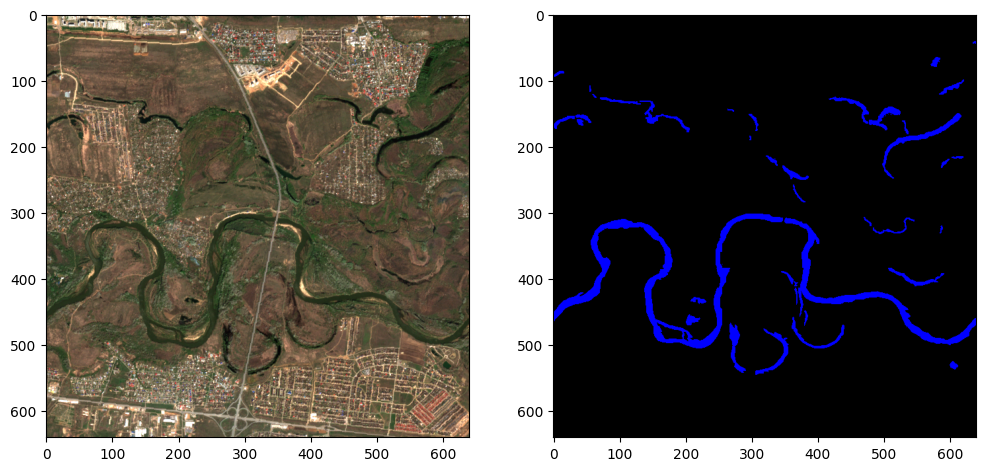

In [21]:
num = 19
plot_data(f'data/images/tile_2_{num}.tif', f'data/masks/tile_2_{num}.tif')

# Reading Data and creating Dataloader example in Pytorch

In [22]:
def image_padding(image, target_size=640):
    """
    Pad an image to a target size using reflection padding.
    """
    height, width = image.shape[1:3]
    pad_height = max(0, target_size - height)
    pad_width = max(0, target_size - width)
    padded_image = np.pad(image, ((0, 0), (0, pad_height),
                                  (0, pad_width)), mode='reflect')
    height, width = padded_image.shape[1:3]
    return padded_image


def mask_padding(mask, target_size=640):
    """
    Pad a mask to a target size using reflection padding.
    """
    height, width = mask.shape
    pad_height = max(0, target_size - height)
    pad_width = max(0, target_size - width)
    padded_mask = np.pad(mask, ((0, pad_height), (0, pad_width)),
                         mode='reflect')
    return padded_mask

In [23]:
def get_data_list(img_path):
    """
    Retrieves a list of file names from the given directory.
    """
    name = []
    for _, _, filenames in os.walk(img_path): # given a directory iterates over the files
        for filename in filenames:
            f = filename.split('.')[0]
            name.append(f)

    df =  pd.DataFrame({'id': name}, index = np.arange(0, len(name))
                       ).sort_values('id').reset_index(drop=True)
    df = df['id'].values

    return np.delete(df, 0)

In [24]:
class WaterDataset(Dataset):
    """
    A custom dataset class for loading and preprocessing paired image and mask files for water segmentation.

    Attributes:
    ----------
    img_path : str
        Directory path to the input image files.
    mask_path : str
        Directory path to the mask files corresponding to each image.
    file_names : list of str
        List of file names (without extensions) for the image and mask files to be loaded.

    Methods:
    -------
    __len__()
        Returns the total number of image-mask pairs in the dataset.
    
    __getitem__(idx)
        Retrieves the image and mask at the specified index `idx`, applies padding, and returns them.
    
    Examples:
    --------
    >>> ds = WaterDataset(img_path='data/images/', mask_path='data/masks/', file_names=data_list)
    >>> dl = DataLoader(ds)
    
    The DataLoader `dl` can then be used to retrieve batches of paired images and masks.

    """
    def __init__(self, img_path, mask_path, file_names):
        self.img_path = img_path
        self.mask_path = mask_path
        self.file_names = file_names

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        with rasterio.open(self.img_path + self.file_names[idx] + '.tif') as fin:
            image = fin.read()
        image = image_padding(image).astype(np.float32)

        with rasterio.open(self.mask_path + self.file_names[idx] + '.tif') as fin:
            mask = fin.read(1)
        mask = mask_padding(mask)

        return image, mask


In [25]:
data_list = get_data_list('data/images/')

In [26]:
data_list[:2]

array(['tile_2_1', 'tile_2_10'], dtype=object)

In [27]:
ds = WaterDataset(
    img_path='data/images/',
    mask_path='data/masks/',
    file_names=data_list
)
dl = DataLoader(ds)
dl

In [28]:
print("Dataset size:", len(ds))
print("Number of batches:", len(dl))

Dataset size: 271
Number of batches: 271


**Here we have one Sentinel-2A image with 10 channels:**


| Name | Description                                          | Resolution |
|------|------------------------------------------------------|------------|
| B02  | Blue, 492.4 nm (S2A), 492.1 nm (S2B)                 | 10m        |
| B03  | Green, 559.8 nm (S2A), 559.0 nm (S2B)                | 10m        |
| B04  | Red, 664.6 nm (S2A), 665.0 nm (S2B)                  | 10m        |
| B05  | Vegetation red edge, 704.1 nm (S2A), 703.8 nm (S2B)  | 20m        |
| B06  | Vegetation red edge, 740.5 nm (S2A), 739.1 nm (S2B)  | 20m        |
| B07  | Vegetation red edge, 782.8 nm (S2A), 779.7 nm (S2B)  | 20m        |
| B08  | NIR, 832.8 nm (S2A), 833.0 nm (S2B)                  | 10m        | 
| B8A  | Narrow NIR, 864.7 nm (S2A), 864.0 nm (S2B)           | 20m        |
| B11  | SWIR, 1613.7 nm (S2A), 1610.4 nm (S2B)               | 20m        |
| B12  | SWIR, 2202.4 nm (S2A), 2185.7 nm (S2B)               | 20m        |

**And mask with values from 0 to 1:**

0. backgound
1. water

# Inference

In [29]:
# In inference you should have pipline read big image devide it into tiles and inference and then concat result into big mask and save to geoTiff

In [30]:
# Here is example of how to save result to geoTiff
with rasterio.open('path_to_image') as multi_band_src:
    image = multi_band_src.read()
    meta = multi_band_src.meta

# Split image to tile, inference and concat 
predict = None # model.predict(image)

meta['count'] = 1

with rasterio.open('path_to_output_geoTiff', 'w', **meta) as fout:
    fout.write(predict, 1)

RasterioIOError: path_to_image: No such file or directory

### !!! Remark: If you see the image with the same id but {_01} and {_02}, it means that first one is image before flood and the second one after